#Context

In this day and age, there are bike sharing systems in cities all around the world. With these systems, people can register an account and rent bikes at certain checkpoints scattered around a geographical area. It's cheap, convenient and good for the environment.

Because of this developing area of urban planning and implementation, having a greater understanding of usage patterns for these services can contribute greatly to cities and society overall.

The dataset below contains information about users of bike sharing systems and the conditions of when the service is used such as temperature, weather and time of year.

In this notebook, I will conduct a full analysis of this dataset and use it to create a regression model that can accurately predict the number of people using a bike system on a given day depending on weather conditions, time of year and other useful features.

Link to the dataset: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

Regarding the creator of the dataset I will be analyzing, full credit goes to Hadi Fanaee-T, the donator of the dataset to the UCI Machine Learning Repository. Now, let's get started!

#Data Dictionary

- instant: This is an ID number and index for the row.

- dtheday: This is the exact date of the row instance containing day, month and year.

- season: This is the season of the instance. (1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall)

- yr: This is the year of the instance.

- mnth: This is the month of the instance. (month 1-12)

- hr: This is the hour of the instance. (0-23)

- holiday: This is whether or not the instance occurred on a holiday. (1 = yes, 0 = no)

- weekday: This is the day of the week of the instance. (day 1 - 7)

- workingday: This is whether or not the instance is a working day, meaning not a weekend or a holiday. 1 = yes, 0 = no)

- weathersit: This is how cloudy the instance weather is. (1 = Clear, 2 = A few clouds, 3 = Overcast)

- temp: This is the normalized instance temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale).

- ntemp: This is the normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale).

- hum: This is the normalized instance humidity. The values are divided to 100 (max).

- windspeed: This is the normalized instance wind speed. The values are divided to 67 (max).

- casual: This is the count of casual users of bike sharing services per instance.

- registered: This is the count of registered users of bike sharing services per instance.

- cnt: This is the total count of casual users and registered users per instance. It will be my target.

#Imports and Overview

In [ ]:
!pip install outlier_utils
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from outliers import smirnov_grubbs as grubbs
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
file = '/content/drive/MyDrive/Machine Learning Project/day.csv'
df = pd.read_csv(file)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None
(731, 16)


In [ ]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Observations:

The dataset is quite small, only 731 rows, but lots of features.

The most useful target feature is probably [cnt].

The [cnt] feature has a high mean and extremely varied range (min = 22, max = 8714).

#Cleaning and Preprocessing

The dataset came pretty clean, so there are only a couple of small things to tweak.

I'll drop the [dteday] right now because all of the relevant information it contains is organized elsewhere ([mnth, yr']). I will also remove [instant], as it's only meant to serve as an index.

In [ ]:
df = df.drop(['dteday', 'instant'], axis = 1)

In [ ]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  casual      731 non-null    int64  
 12  registered  731 non-null    int64  
 13  cnt         731 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 80.1 KB


/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


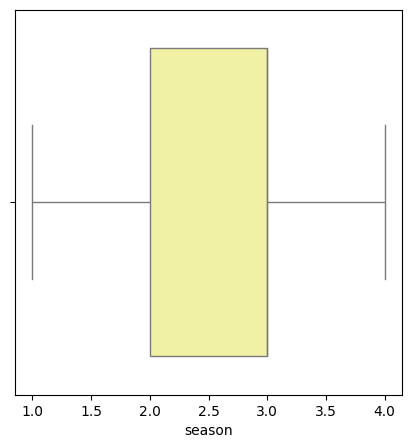

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


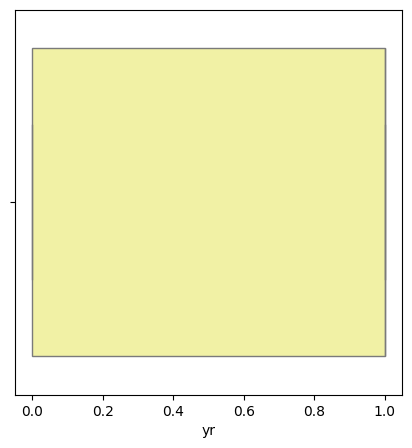

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


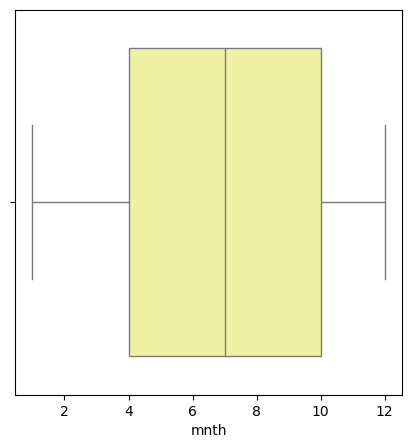

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


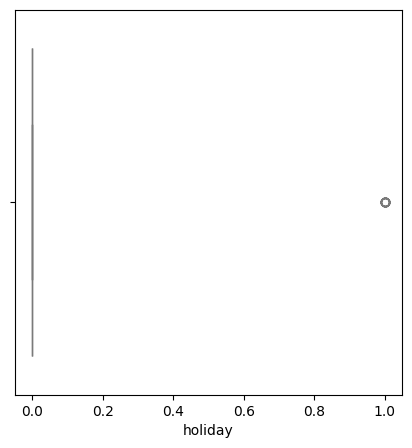

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


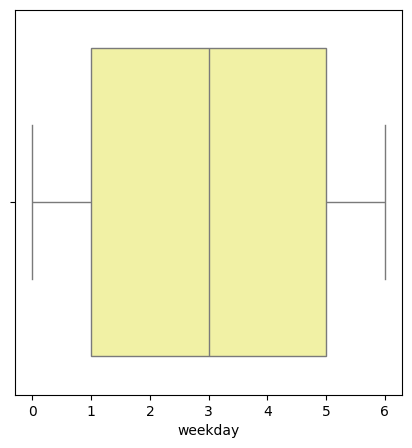

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


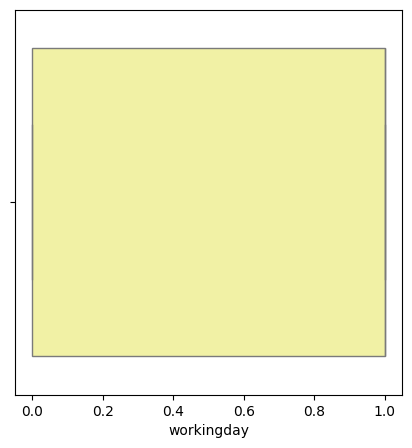

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


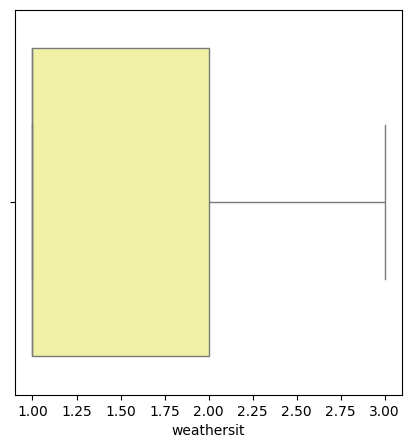

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


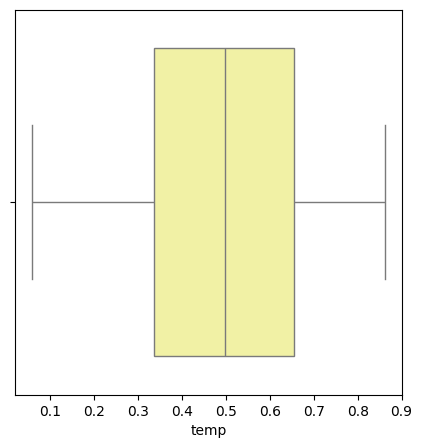

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


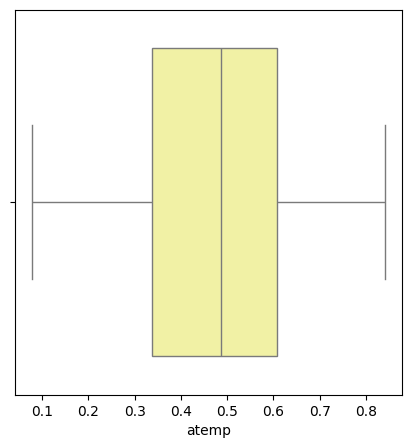

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


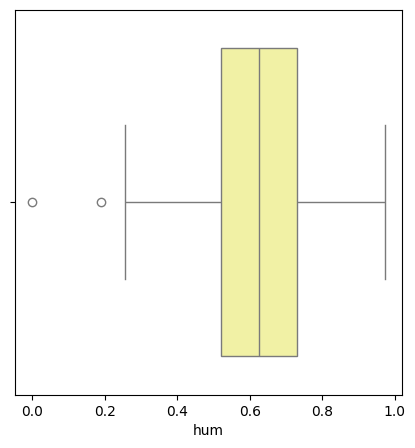

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


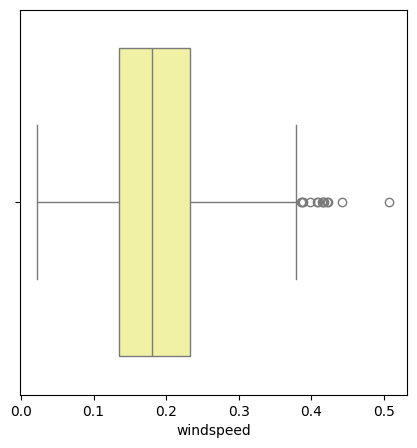

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


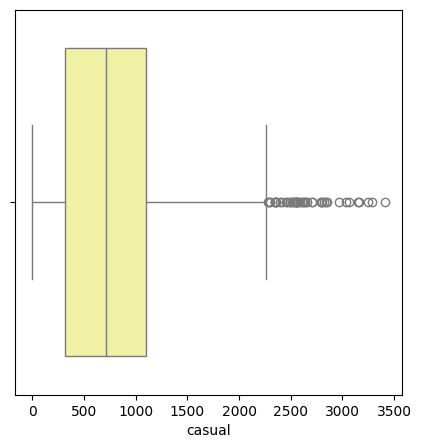

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


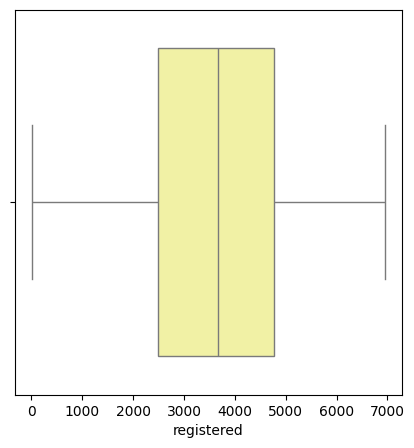

/tmp/ipython-input-369-738883368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = i, palette = 'terrain')


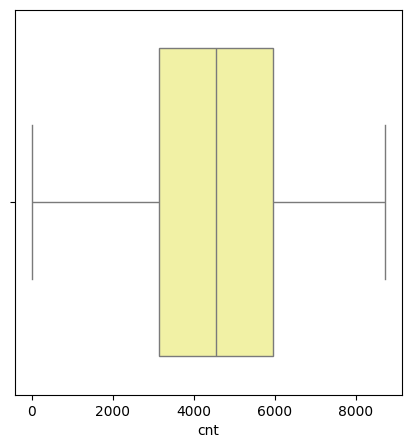

In [ ]:
numcols = df.select_dtypes(include = ['float64', 'int64'])
catcols = df.select_dtypes(include = 'object')

for i in df.columns:
  plt.figure(figsize = (5,5))
  sns.boxplot(df, x = i, palette = 'terrain')
  plt.show()

According to the boxplots above, the relevant outliers are [windspeed], [hum] and [casual].

In [ ]:
outliers = ['windspeed', 'hum', 'casual']

def IQRF(col):
	Q1 = df[col].quantile(0.25)
	Q3 = df[col].quantile(0.75)
	IQR = Q3 - Q1
	lb = Q1 - 1.5 * IQR
	ub = Q3 + 1.5 * IQR
	return (df[col] < lb) | (df[col] > ub)

for col in df[outliers]:
  df.loc[IQRF(col), col] = np.nan

print(df[outliers].isna().sum())

windspeed    13
hum           2
casual       44
dtype: int64


In [ ]:
wmean = df['windspeed'].mean()
hmean = df['hum'].mean()
cmean = df['casual'].mean()

wmedian = df['windspeed'].median()
hmedian = df['hum'].median()
cmedian = df['casual'].median()

print(f'The means are: {wmean}, {hmean} and {cmean}')
print(f'The medians are: {wmedian}, {hmedian} and {cmedian}')

The means are: 0.18639180459610027, 0.6293589067215364 and 732.0101892285298
The medians are: 0.178802, 0.6275 and 674.0


For [windspeed] and [hum], I will fill the outliers with the mean. However, for [casual], I will use the median since there is a significant difference between the mean and the median in this feature, which would affect the overall distribution.

In [ ]:
df['windspeed'] = df['windspeed'].fillna(df['windspeed'].mean())
df['hum'] = df['hum'].fillna(df['hum'].mean())
df['casual'] = df['casual'].fillna(df['casual'].median())

#Exploratory Analysis

##Univariate Analysis: Categorical

/tmp/ipython-input-38-489187452.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df, x = col, palette = 'terrain')


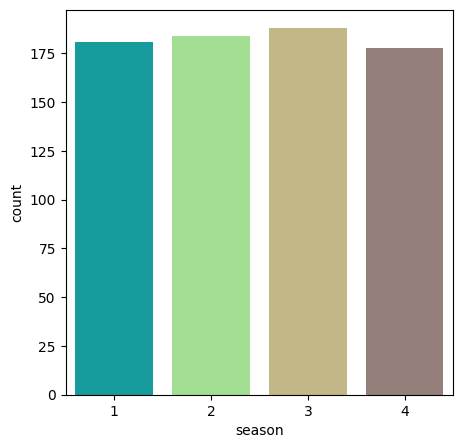

/tmp/ipython-input-38-489187452.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df, x = col, palette = 'terrain')


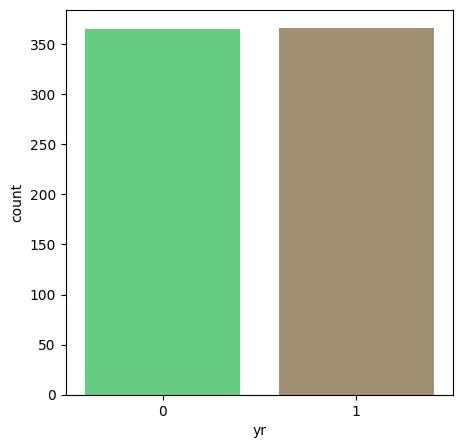

/tmp/ipython-input-38-489187452.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df, x = col, palette = 'terrain')


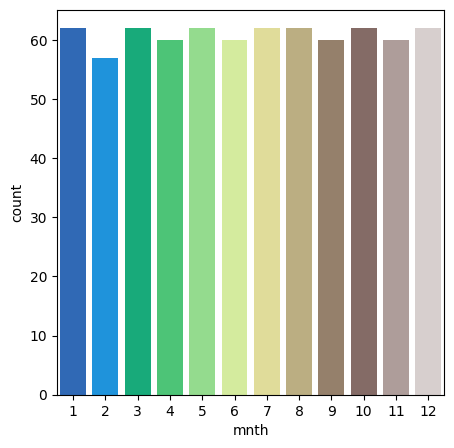

/tmp/ipython-input-38-489187452.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df, x = col, palette = 'terrain')


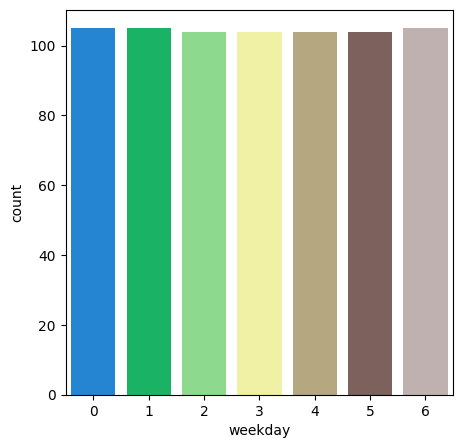

In [ ]:
equalist = ['season', 'yr', 'mnth', 'weekday']

for col in equalist:
  plt.figure(figsize = (5,5))
  sns.countplot(df, x = col, palette = 'terrain')
  plt.show()

Observation:

The items in these four feature columns are evenly distributed with little variation.

/tmp/ipython-input-39-719261018.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df, x = 'weathersit', palette = 'terrain')


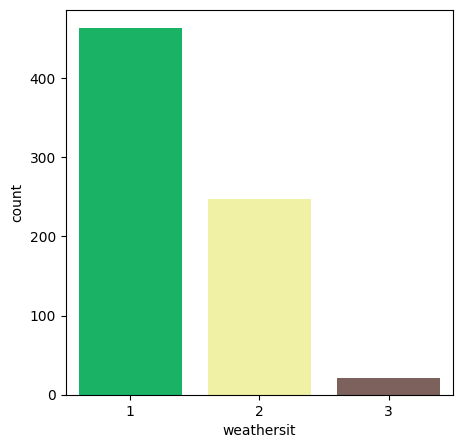

In [ ]:
plt.figure(figsize = (5,5))
sns.countplot(df, x = 'weathersit', palette = 'terrain')
plt.show()

Observation:

- The most common kind of weather was clear skies, followed by some clouds and overcast. There were very few overcast days.

/tmp/ipython-input-24-675250154.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df, x = 'workingday', palette = 'terrain')


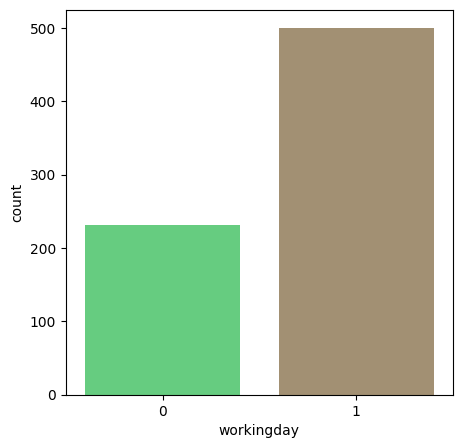

In [ ]:
plt.figure(figsize = (5,5))
sns.countplot(df, x = 'workingday', palette = 'terrain')
plt.show()

Observation:

- There were (obviously) more working days than not in these 2 years.

##Univariate Analysis: Numeric

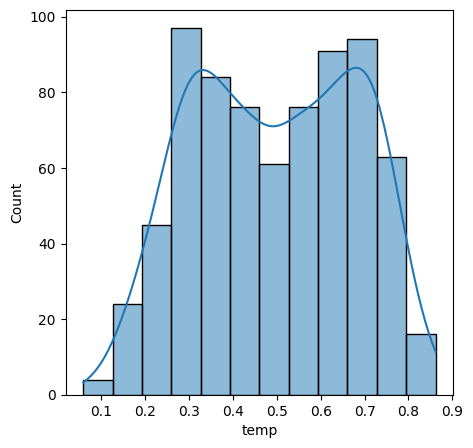

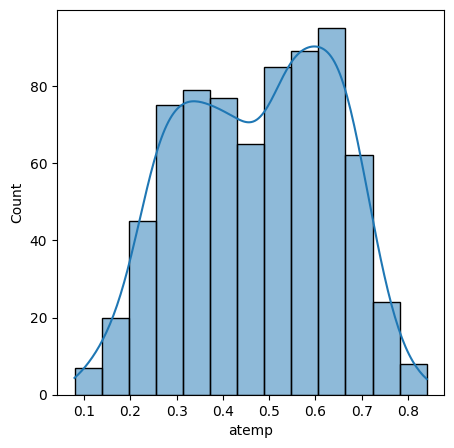

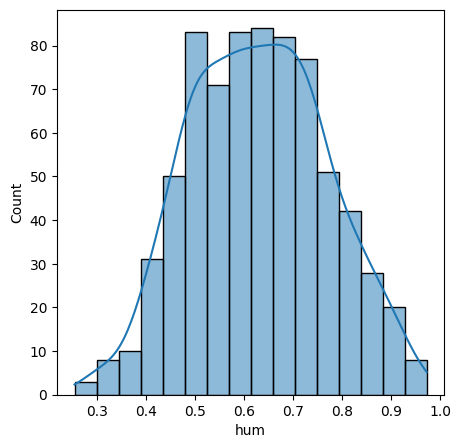

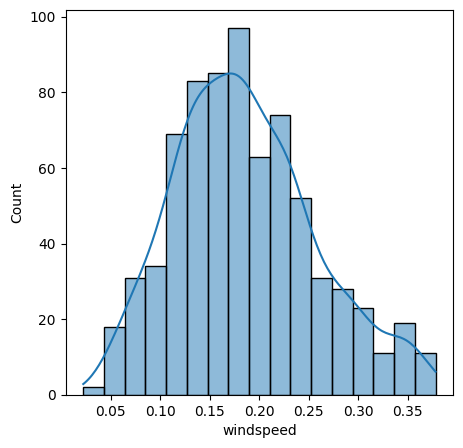

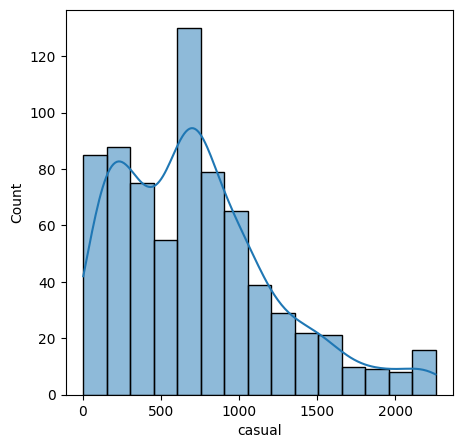

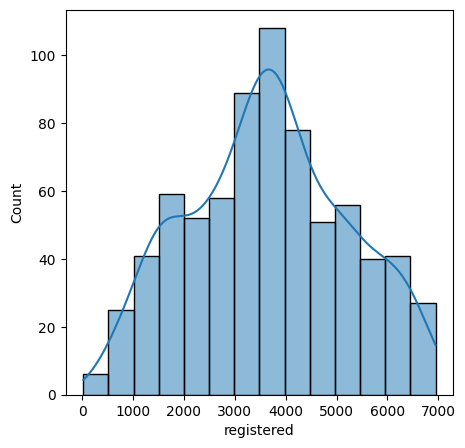

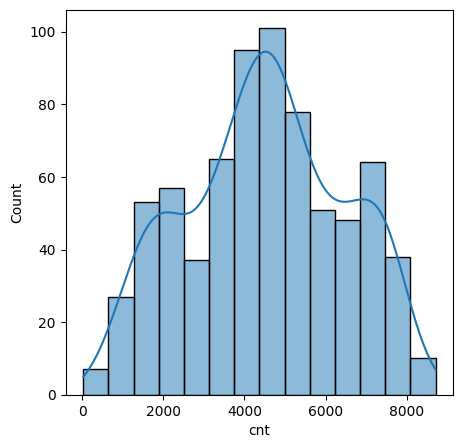

In [ ]:
distcols = ['temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt']

for col in distcols:
  plt.figure(figsize = (5,5))
  sns.histplot(df, x = col, kde = True)
  plt.show()

Observations:

- Most of the feature distributions appear mostly normal. The most abnormal ones are [temp] and [atemp], 2 related columns. [casual] is also skewed heavily right, most likely due to outlier removal. (I'm not too concerned about this, since it is only being used in the exploratory analysis. It will be removed from the model for other reasons.)

- [hum] is slightly skewed to the left.

- [windspeed] is slightly skewed to the right.

##Bivariate Analysis:

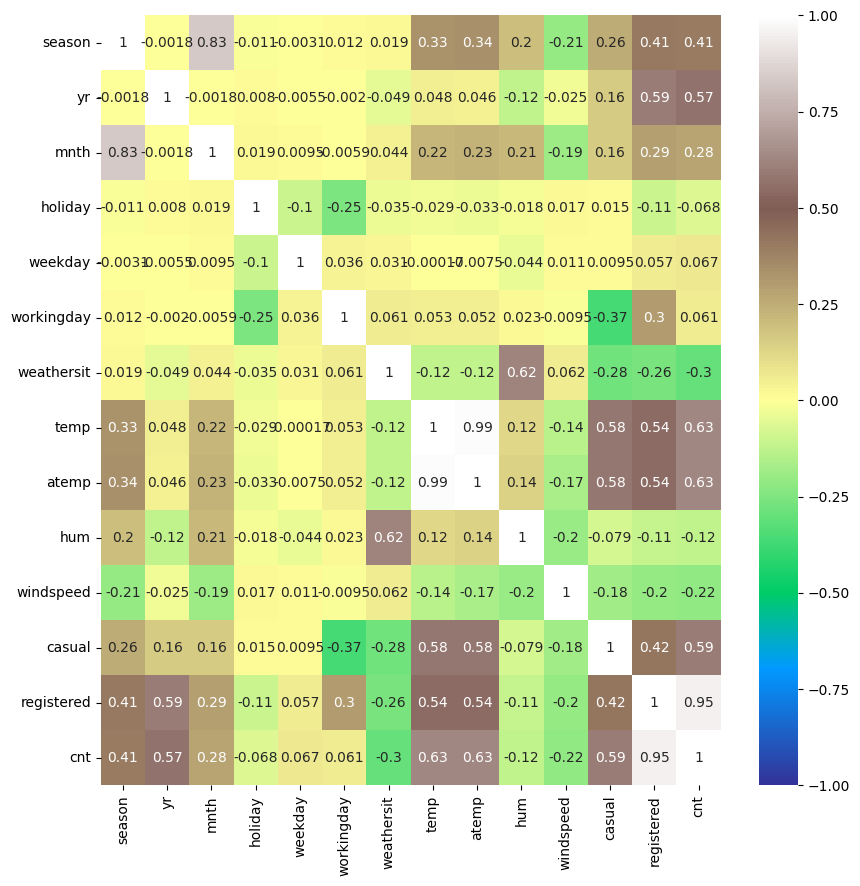

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'terrain')
plt.show()

Observations:

There are a variety of strong correlations, but I will only investigate a few for the following reasons:

- It is obvious that [season] and [mnth] would be related, and the correlation does not warrant investigation.

- It is obvious that [season] would affect [temp] and [atemp], and the correlation does not warrant investigation.

- It is obvious that [weathersit] would affect [hum] (humidity), and the correlation does not warrant investigation.

- It is obvious that [workingday] and [holiday] would be related, and does not warrant investigation.

This leaves us with several strong relationships in the [cnt] [registered] and [casual] columns. I will run some ANOVA Tests and 1-Student's Tests to see how related these features are to [cnt]. Meanwhile, I will look into [casual] and [registered] users and their relationships with the other features in the multivariate analysis.

###Statistical Hypothesis Test: Count and Year

/tmp/ipython-input-42-2815988433.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(df, x = 'yr', y = 'cnt', palette = 'terrain', ci = False)
/tmp/ipython-input-42-2815988433.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x = 'yr', y = 'cnt', palette = 'terrain', ci = False)


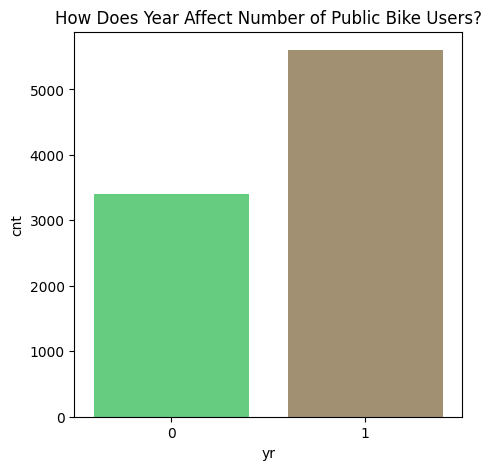

In [ ]:
plt.figure(figsize = (5,5))
sns.barplot(df, x = 'yr', y = 'cnt', palette = 'terrain', ci = False)
plt.title('How Does Year Affect Number of Public Bike Users?')
plt.show()

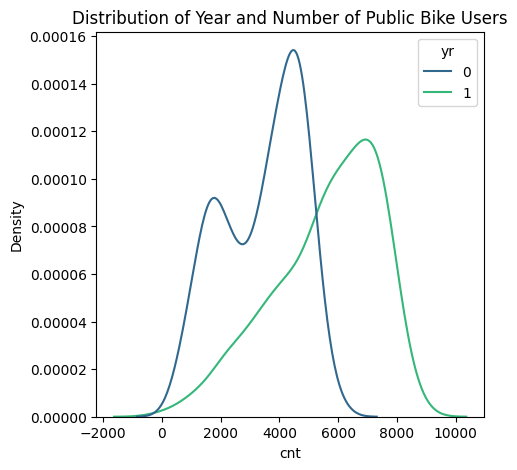

In [ ]:
plt.figure(figsize = (5,5))
sns.kdeplot(df, x = 'cnt', palette = 'viridis', hue = 'yr')
plt.title('Distribution of Year and Number of Public Bike Users')
plt.show()

In [ ]:
eleven = df[df['yr'] == 0]['cnt']
twelve = df[df['yr'] == 1]['cnt']

stat, p = ttest_ind(eleven, twelve, alternative = 'greater')
if p > 0.05:
    print("P-value is {}".format(p))
    print('We cannot reject the null hypothesis, the average count for 2011 is not greater 2012.')
else:
    print("P-value is {}".format(p))
    print('We can reject the null hypothesis, the average count for 2011 is greater than 2012')

P-value is 1.0
We cannot reject the null hypothesis, the average count for 2011 is not greater 2012.


###Statistical Hypothesis Test: Count and Season

/tmp/ipython-input-45-3844605781.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(df, x = 'season', y = 'cnt', palette = 'terrain', ci = False)
/tmp/ipython-input-45-3844605781.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x = 'season', y = 'cnt', palette = 'terrain', ci = False)


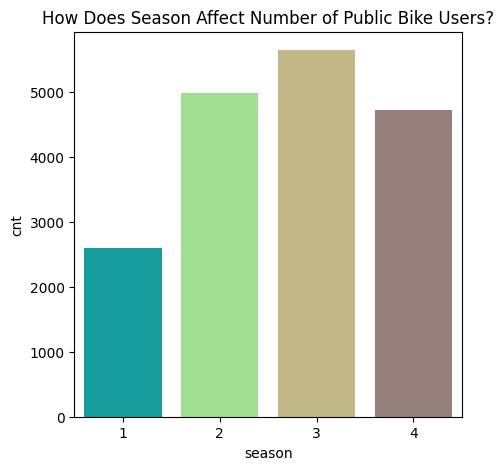

In [ ]:
plt.figure(figsize = (5,5))
sns.barplot(df, x = 'season', y = 'cnt', palette = 'terrain', ci = False)
plt.title('How Does Season Affect Number of Public Bike Users?')
plt.show()

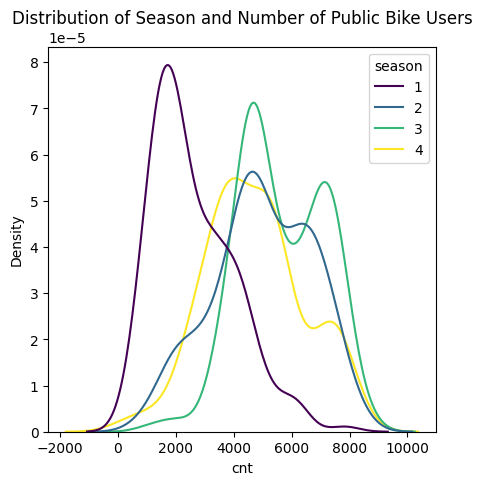

In [ ]:
plt.figure(figsize = (5,5))
sns.kdeplot(df, x = 'cnt', palette = 'viridis', hue = 'season')
plt.title('Distribution of Season and Number of Public Bike Users')
plt.show()

In [ ]:
winter = df[df['season'] == 1]['cnt']
spring = df[df['season'] == 2]['cnt']
summer = df[df['season'] == 3]['cnt']
fall = df[df['season'] == 4]['cnt']

stat, p = f_oneway(winter, spring, summer, fall)
if p > 0.05:
    print(f'P-value is {p}')
    print("We cannot reject the null hypothesis. The average count  is not different for all samples")
else:
    print(f'P-value is {p}')
    print("We can reject the null hypothesis. The average count is different for different samples")

P-value is 6.720391362913176e-67
We can reject the null hypothesis. The average count is different for different samples


###Statistical Hypothesis Test: Count and Month

/tmp/ipython-input-48-4189250819.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(df, x = 'mnth', y = 'cnt', palette = 'terrain', ci = False)
/tmp/ipython-input-48-4189250819.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x = 'mnth', y = 'cnt', palette = 'terrain', ci = False)


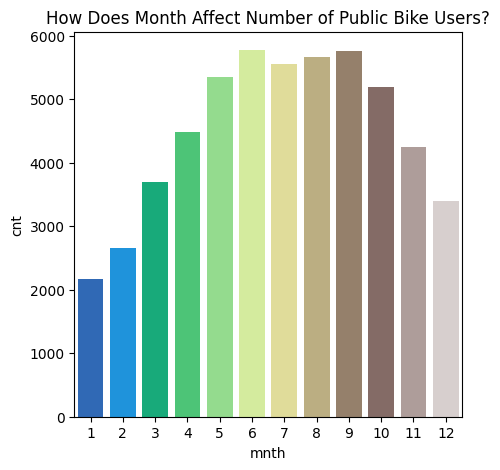

In [ ]:
plt.figure(figsize = (5,5))
sns.barplot(df, x = 'mnth', y = 'cnt', palette = 'terrain', ci = False)
plt.title('How Does Month Affect Number of Public Bike Users?')
plt.show()

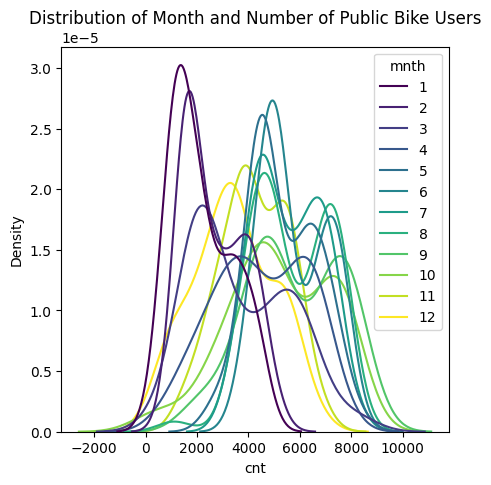

In [ ]:
plt.figure(figsize = (5,5))
sns.kdeplot(df, x = 'cnt', palette = 'viridis', hue = 'mnth')
plt.title('Distribution of Month and Number of Public Bike Users')
plt.show()

In [ ]:
jan = df[df['mnth'] == 1]['cnt']
feb = df[df['mnth'] == 2]['cnt']
mar = df[df['mnth'] == 3]['cnt']
apr = df[df['mnth'] == 4]['cnt']
may = df[df['mnth'] == 5]['cnt']
jun = df[df['mnth'] == 6]['cnt']
jul = df[df['mnth'] == 7]['cnt']
aug = df[df['mnth'] == 8]['cnt']
sep = df[df['mnth'] == 9]['cnt']
oct = df[df['mnth'] == 10]['cnt']
nov = df[df['mnth'] == 11]['cnt']
dec = df[df['mnth'] == 12]['cnt']

stat, p = f_oneway(jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec)
if p > 0.05:
    print(f'P-value is {p}')
    print("We cannot reject the null hypothesis. The average count  is not different for all samples")
else:
    print(f'P-value is {p}')
    print("We can reject the null hypothesis. The average count is different for different samples")

P-value is 4.2510770151023976e-70
We can reject the null hypothesis. The average count is different for different samples


###Statistical Hypothesis Test: Count and Year



/tmp/ipython-input-51-718358303.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x = 'weathersit', y = 'cnt', palette = 'terrain')


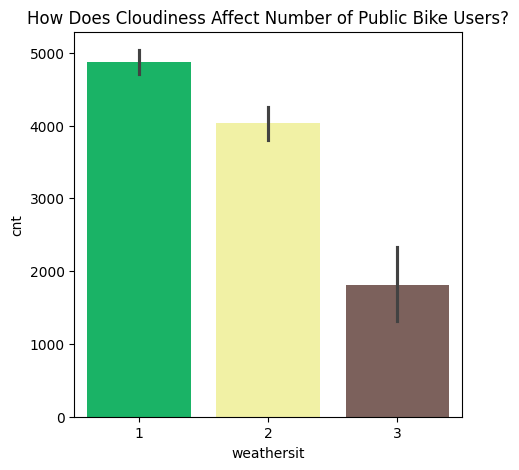

In [ ]:
plt.figure(figsize = (5,5))
sns.barplot(df, x = 'weathersit', y = 'cnt', palette = 'terrain', ci = False)
plt.title('How Does Cloudiness Affect Number of Public Bike Users?')
plt.show()

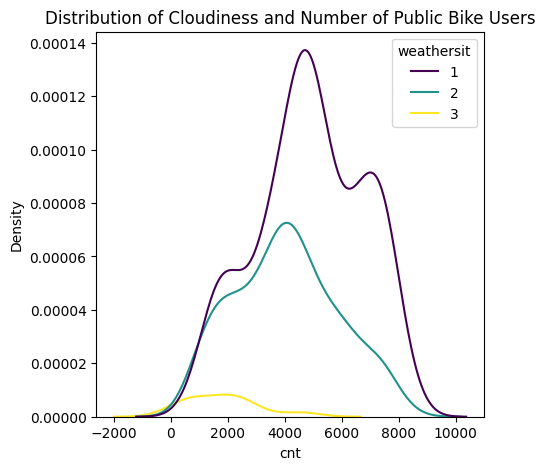

In [ ]:
plt.figure(figsize = (5,5))
sns.kdeplot(df, x = 'cnt', palette = 'viridis', hue = 'weathersit')
plt.title('Distribution of Cloudiness and Number of Public Bike Users')
plt.show()

In [ ]:
clear = df[df['weathersit'] == 1]['cnt']
few_clouds = df[df['weathersit'] == 2]['cnt']
overcast = df[df['weathersit'] == 3]['cnt']

stat, p = f_oneway(clear, few_clouds, overcast)
if p > 0.05:
    print(f'P-value is {p}')
    print("We cannot reject the null hypothesis. The average count  is not different for all samples")
else:
    print(f'P-value is {p}')
    print("We can reject the null hypothesis. The average count is different for different samples")

P-value is 3.106317270053755e-17
We can reject the null hypothesis. The average count is different for different samples


###Correlation Test: Count and Temperature

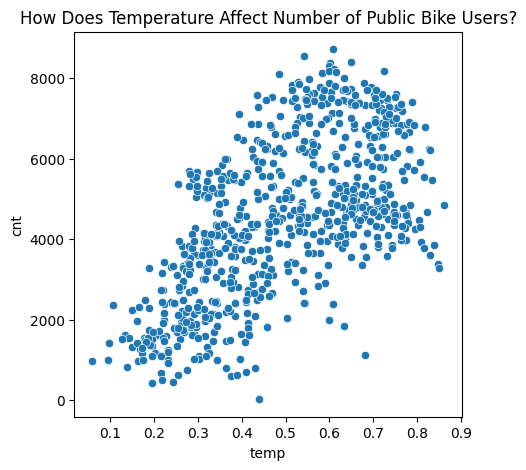

In [ ]:
plt.figure(figsize = (5,5))
sns.scatterplot(df, x = 'temp', y = 'cnt')
plt.title('How Does Temperature Affect Number of Public Bike Users?')
plt.show()

In [ ]:
count = df['cnt']
temp = df['temp']

stat, p = pearsonr(count, temp)
if p > 0.05:
    print(p)
    print("We cannot reject the null hypothesis. Count and Temperature are independent and have no linear relationship")
else:
    print(p)
    print("We can reject the null hypothesis. Count and Temperature are dependent and have linear relationship")

2.8106223975893466e-81
We can reject the null hypothesis. Count and Temperature are dependent and have linear relationship


###Correlation Test: Count and Percieved Temperature

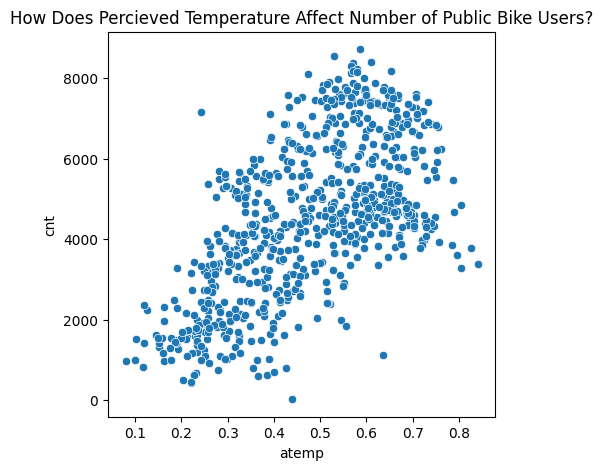

In [ ]:
plt.figure(figsize = (5,5))
sns.scatterplot(df, x = 'atemp', y = 'cnt')
plt.title('How Does Percieved Temperature Affect Number of Public Bike Users?')
plt.show()

In [ ]:
count = df['cnt']
atemp = df['atemp']

stat, p = pearsonr(count, atemp)
if p > 0.05:
    print(p)
    print("We cannot reject the null hypothesis. Count and Percieved Temperature are independent and have no linear relationship")
else:
    print(p)
    print("We can reject the null hypothesis. Count and Percieved Temperature are dependent and have linear relationship")

1.8545041252837507e-82
We can reject the null hypothesis. Count and Percieved Temperature are dependent and have linear relationship


Observations:

- Only the relationship between [cnt] and [yr] accepted the null hypothesis.

- All other correlations observed on the heatmap rejected the null hypothesis when tested, proving their correlation.

##Multivariate Analysis:

This dataset comes with several features, including weather conditions and type of day. However, the goal of this analysis is not weather prediction or studying distribution of holidays, but rather seeing how these factors affect the number of people using bike sharing systems.

Therefore, for this multivariate analysis, I will be looking into the distribution of causal users and registered users based on certain conditions (weather and type of day.)

/tmp/ipython-input-60-2682356478.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(df_long, x = 'mnth', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)


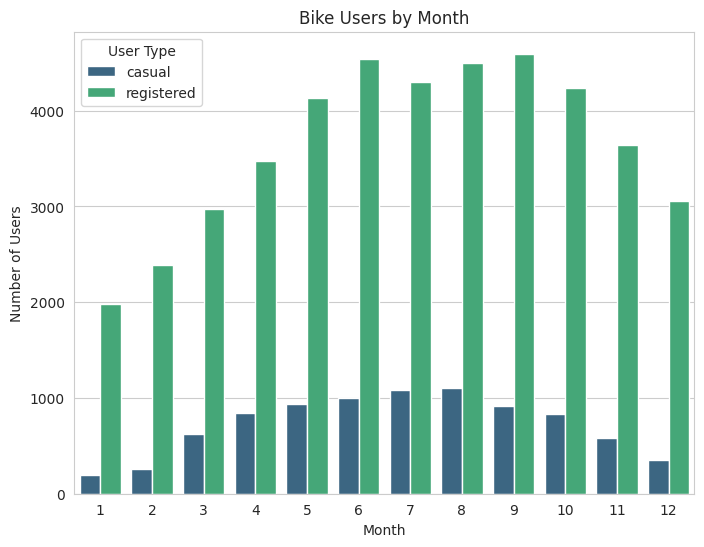

In [ ]:
df_long = df.melt(id_vars = 'mnth', value_vars = ['casual', 'registered'],
                  var_name = 'user_type', value_name = 'count')

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(df_long, x = 'mnth', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)

plt.title("Bike Users by Month")
plt.ylabel("Number of Users")
plt.xlabel("Month")
plt.legend(title = "User Type")
plt.show()

Observations:

- There are a couple of small distribution differences between casual and registered users. For registered users, the most popular months are September and June. Meanwhile for casual users, the most popular months are June and July. Due to data sample size however, everything is pretty close and the distribution is similar between the two.

/tmp/ipython-input-61-750493697.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(df_long, x = 'season', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)


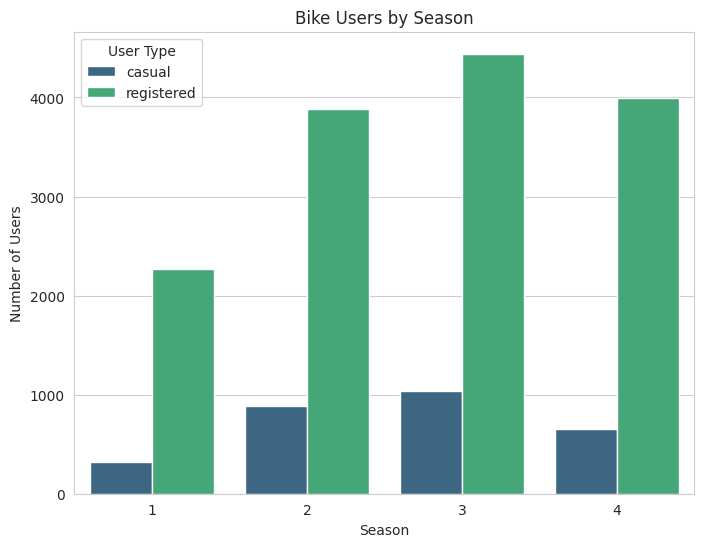

In [ ]:
df_long = df.melt(id_vars = 'season', value_vars = ['casual', 'registered'],
                  var_name = 'user_type', value_name = 'count')

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(df_long, x = 'season', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)

plt.title("Bike Users by Season")
plt.ylabel("Number of Users")
plt.xlabel("Season")
plt.legend(title = "User Type")
plt.show()

Observations:

- The most popular seasons for casual and registered users is Summer.

- The least popular seasons for casual and registered users is Winter.

- There's an odd distribution blip with Spring, there's more casual users than normal but less registered users than normal.

/tmp/ipython-input-62-2794918106.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(df_long, x = 'weathersit', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)


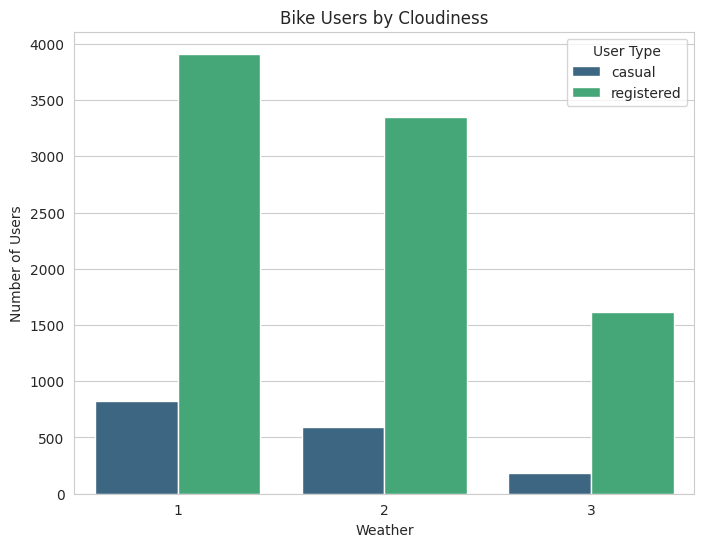

In [ ]:
df_long = df.melt(id_vars = 'weathersit', value_vars = ['casual', 'registered'],
                  var_name = 'user_type', value_name = 'count')

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(df_long, x = 'weathersit', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)

plt.title("Bike Users by Cloudiness")
plt.ylabel("Number of Users")
plt.xlabel("Weather")
plt.legend(title = "User Type")
plt.show()

Observations:

- The less clouds, the more casual and registered users.

/tmp/ipython-input-63-1597324328.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(df_long, x = 'holiday', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)


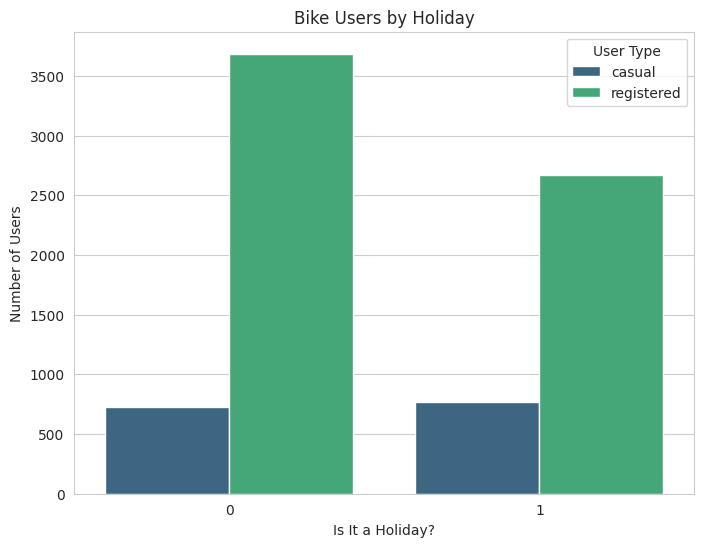

In [ ]:
df_long = df.melt(id_vars = 'holiday', value_vars = ['casual', 'registered'],
                  var_name = 'user_type', value_name = 'count')

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(df_long, x = 'holiday', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)

plt.title("Bike Users by Holiday")
plt.ylabel("Number of Users")
plt.xlabel("Is It a Holiday?")
plt.legend(title = "User Type")
plt.show()

Observations:

- The distribution for casual and registered users is reveresed. On a holiday there is more casual users than normal, and on normal days, there is more registered users than normal. However, there are still more registered users overall for both categories due to data distribution.

In [ ]:
df['a_temp_bin'] = pd.cut(
    df['atemp'],
    bins=4,
    labels=['Cold', 'Cool', 'Warm', 'Hot']
)

/tmp/ipython-input-65-4251173968.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(df_long, x = 'a_temp_bin', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)


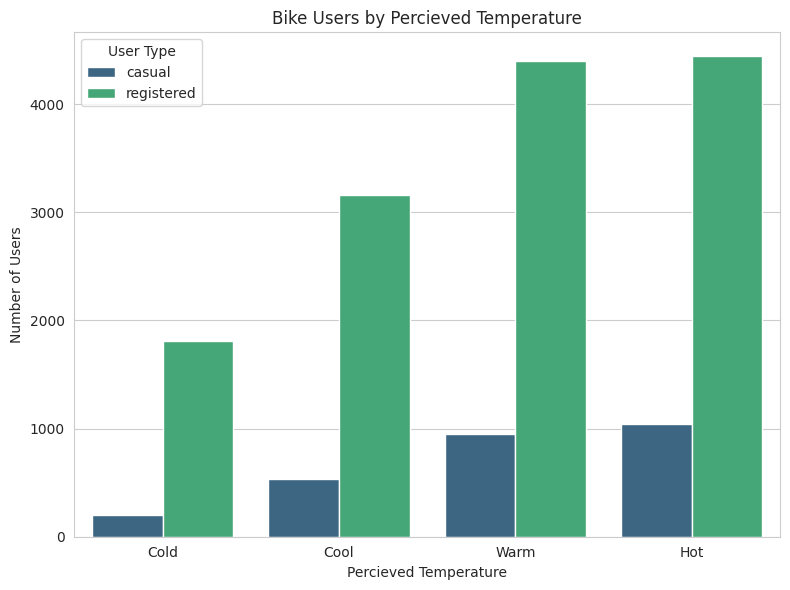

In [ ]:
df_long = df.melt(id_vars = 'a_temp_bin', value_vars = ['casual', 'registered'],
                  var_name = 'user_type', value_name = 'count')

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(df_long, x = 'a_temp_bin', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)

plt.title("Bike Users by Percieved Temperature")
plt.ylabel("Number of Users")
plt.xlabel("Percieved Temperature")
plt.legend(title = "User Type")
plt.tight_layout()
plt.show()

Observations:

- I hypothesized that warm weather would warrant the most users, but it's actually hot weather. This is supported by the fact that Summer is the season with the most users as seen above, so it may be causation and not correlation.

- The warmer the percieved temperature, the more casual and registered users.

In [ ]:
df['windspeed_bin'] = pd.cut(
    df['windspeed'],
    bins = 3,
    labels=['Low', 'Medium', 'High']
)

/tmp/ipython-input-68-2916173909.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(df_long, x = 'windspeed_bin', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)


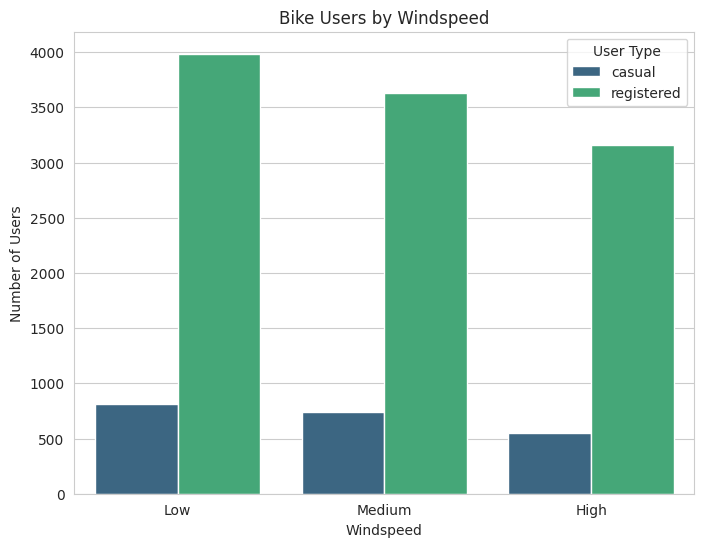

In [ ]:
df_long = df.melt(id_vars = 'windspeed_bin', value_vars = ['casual', 'registered'],
                  var_name = 'user_type', value_name = 'count')

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(df_long, x = 'windspeed_bin', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)

plt.title("Bike Users by Windspeed")
plt.ylabel("Number of Users")
plt.xlabel("Windspeed")
plt.legend(title = "User Type")
plt.show()

Observations:

- The higher the windspeed, the lower the users for both registered users and casual users.

In [ ]:
df['hum_bin'] = pd.cut(
    df['hum'],
    bins = 3,
    labels=['Low', 'Medium', 'High']
)

/tmp/ipython-input-70-646736566.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(df_long, x = 'hum_bin', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)


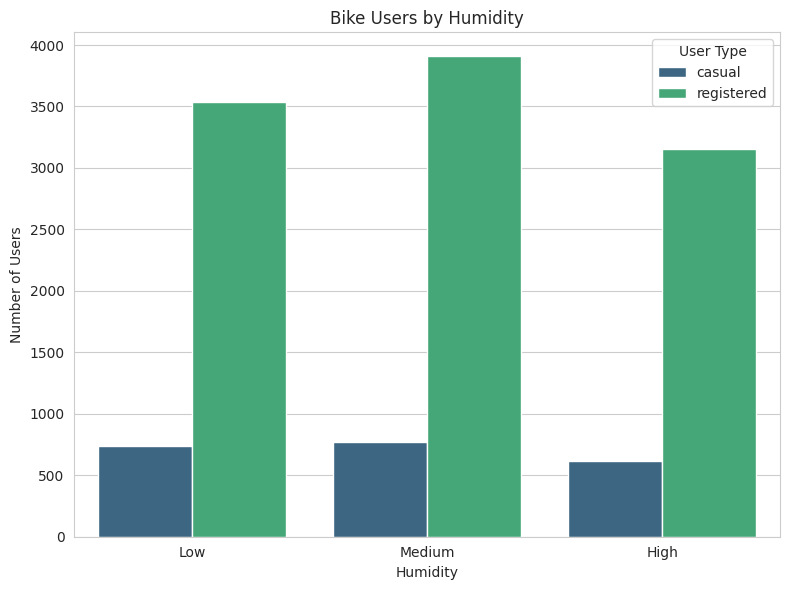

In [ ]:
df_long = df.melt(id_vars = 'hum_bin', value_vars = ['casual', 'registered'],
                  var_name = 'user_type', value_name = 'count')

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(df_long, x = 'hum_bin', y = 'count', hue = 'user_type', palette = 'viridis', ci = None)

plt.title("Bike Users by Humidity")
plt.ylabel("Number of Users")
plt.xlabel("Humidity")
plt.legend(title = "User Type")
plt.tight_layout()
plt.show()

Observations:

- People surprisingly prefer medium humidity over low humidity.

- The distribution of casual users is a little more balance than registered users.

Conclusion:

Since the dataset is relatively small and neat. The data is mostly normal, contains few outliers and is overall sane. However, since the sample size is small, it can lead to low-impact/surface level insights.

There are significantly more registered users than casual, but their distributions are very similar. If one wanted to alter their bike system in a way that affects the overall count, they likely wouldn't need to come up with different solutions for casual and registered users.

The factors that resulted in low counts are: high humidity, high windspeed, cold temperatures, overcast weather and winter months. it paints a picture that people favor warm, comfortable weather over cold weather. This could also do with the fact that most people take their holidays in Summer and therefore have more time to use the bikes. Or it could have to do with both of these factors.